In [1]:
!pip install tensorflow==2.12.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4

In [2]:
!pip install tensorflow-addons
!pip install --upgrade tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [3]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.4 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os
import visualkeras

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.12.0


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [7]:
VGOGH_FILENAMES = tf.io.gfile.glob('/kaggle/input/van-gogh-tfrecord/images.tfrecord')
print('Van Gogh TFRecord Files:', len(VGOGH_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/van-gogh-and-test-pictures/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Van Gogh TFRecord Files: 1
Photo TFRecord Files: 20


In [8]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [9]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [10]:
vgogh_ds = load_dataset(VGOGH_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [11]:
example_vgogh = next(iter(vgogh_ds))
example_photo = next(iter(photo_ds))

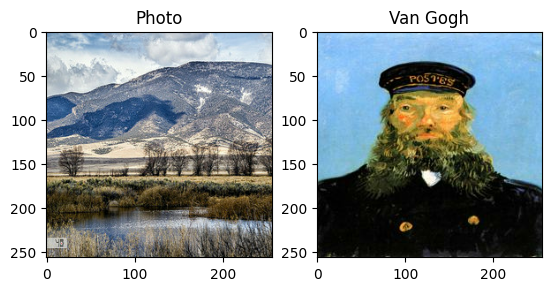

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Van Gogh')
plt.imshow(example_vgogh[0] * 0.5 + 0.5)

# **Building the generator**

In [13]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size - 1, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [14]:
def upsample(filters, size, apply_dropout=False):

    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size - 1, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [15]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.01)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                  2,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
def Discriminator():
    
    initializer = tf.random_normal_initializer(0., 0.01)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 3, strides=3,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    
    #Strides?
    last = tf.keras.layers.Conv2D(1, 3, strides=3,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [17]:
with strategy.scope():
    vgogh_generator = Generator() # transforms photos to Van Gogh-esque paintings
    photo_generator = Generator() # transforms Van Gogh paintings to be more like photos

    vgogh_discriminator = Discriminator() # differentiates real Van Gogh paintings and generated Van Gogh paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [18]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        vgogh_generator,
        photo_generator,
        vgogh_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = vgogh_generator
        self.p_gen = photo_generator
        self.m_disc = vgogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_vgogh, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to vgogh back to photo
            fake_vgogh = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_vgogh, training=True)

            # vgogh to photo back to vgogh
            fake_photo = self.p_gen(real_vgogh, training=True)
            cycled_vgogh = self.m_gen(fake_photo, training=True)

            # generating itself
            same_vgogh = self.m_gen(real_vgogh, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_vgogh = self.m_disc(real_vgogh, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_vgogh = self.m_disc(fake_vgogh, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            vgogh_gen_loss = self.gen_loss_fn(disc_fake_vgogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_vgogh, cycled_vgogh, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            # evaluates total generator loss
            total_vgogh_gen_loss = vgogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vgogh, same_vgogh, self.lambda_cycle)
            #total_vgogh_gen_loss = vgogh_gen_loss + total_cycle_loss + id_loss_vgogh
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            vgogh_disc_loss = self.disc_loss_fn(disc_real_vgogh, disc_fake_vgogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        vgogh_generator_gradients = tape.gradient(total_vgogh_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        vgogh_discriminator_gradients = tape.gradient(vgogh_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(vgogh_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(vgogh_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "vgogh_gen_loss": total_vgogh_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "vgogh_disc_loss": vgogh_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [19]:
with strategy.scope():
    
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [20]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [21]:
with strategy.scope():
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [22]:
with strategy.scope():
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [23]:
with strategy.scope():
    
    vgogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    vgogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        vgogh_generator, photo_generator, vgogh_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = vgogh_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = vgogh_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [25]:
NUMEPOCHS = 5
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((vgogh_ds, photo_ds)),
    epochs=NUMEPOCHS
)

Epoch 1/5
342/342 [==============================] - 726s 2s/step - vgogh_gen_loss: 6.9520 - photo_gen_loss: 7.0037 - vgogh_disc_loss: 0.5351 - photo_disc_loss: 0.5006
Epoch 2/5
342/342 [==============================] - 667s 2s/step - vgogh_gen_loss: 4.7840 - photo_gen_loss: 4.8156 - vgogh_disc_loss: 0.6063 - photo_disc_loss: 0.6058
Epoch 3/5
342/342 [==============================] - 683s 2s/step - vgogh_gen_loss: 4.3946 - photo_gen_loss: 4.3184 - vgogh_disc_loss: 0.5861 - photo_disc_loss: 0.6416
Epoch 4/5
342/342 [==============================] - 676s 2s/step - vgogh_gen_loss: 3.9988 - photo_gen_loss: 3.9636 - vgogh_disc_loss: 0.6447 - photo_disc_loss: 0.6301
Epoch 5/5
342/342 [==============================] - 679s 2s/step - vgogh_gen_loss: 3.7341 - photo_gen_loss: 3.8350 - vgogh_disc_loss: 0.6472 - photo_disc_loss: 0.5838


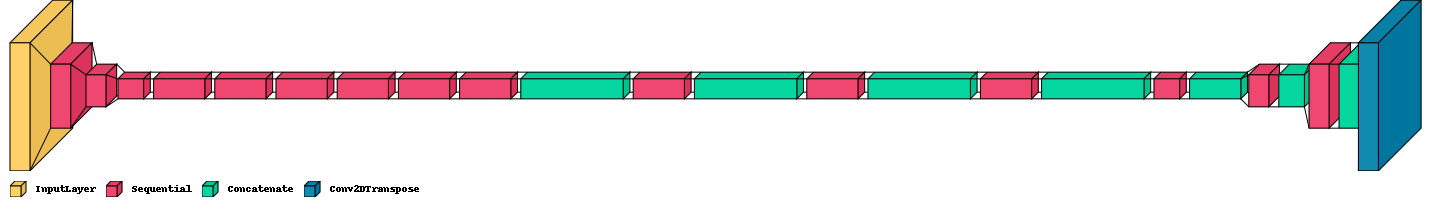

In [26]:
visualkeras.layered_view(vgogh_generator, legend=True, scale_xy=0.5)

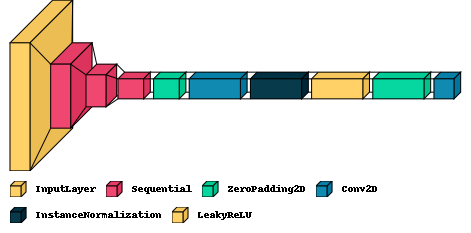

In [27]:
visualkeras.layered_view(vgogh_discriminator, legend=True, scale_xy=0.5)

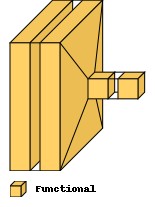

In [28]:
visualkeras.layered_view(cycle_gan_model, legend=True, scale_xy=0.5)

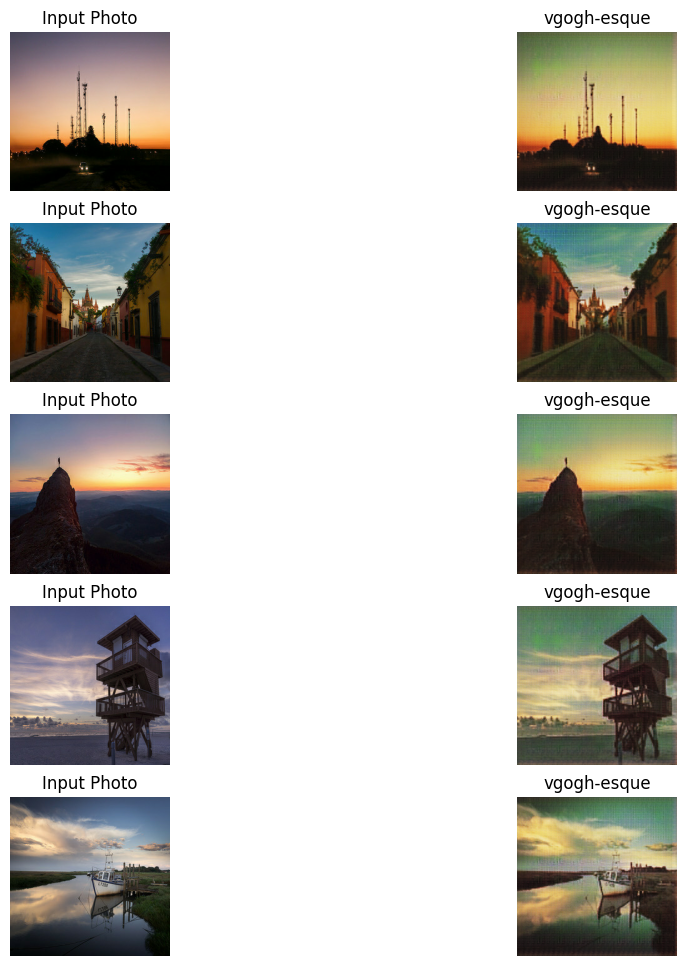

In [29]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.shuffle(342).take(5)):
    prediction = vgogh_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("vgogh-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

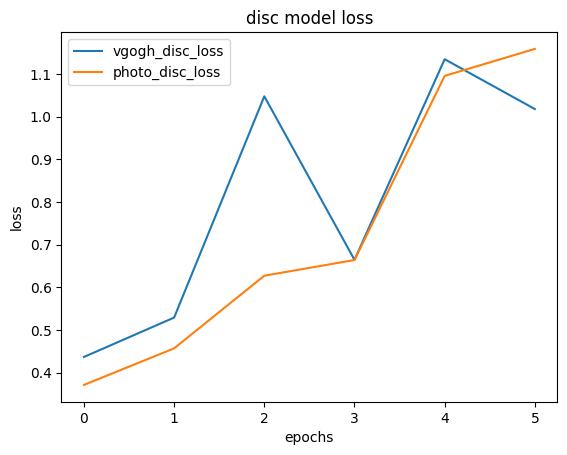

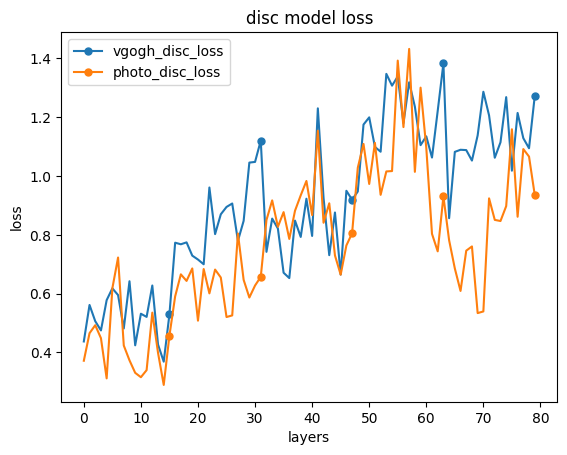

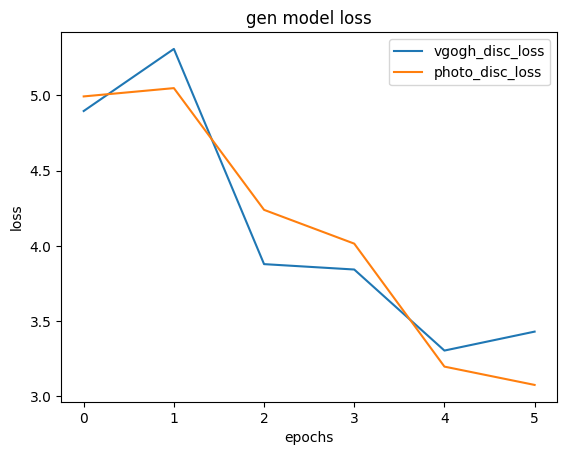

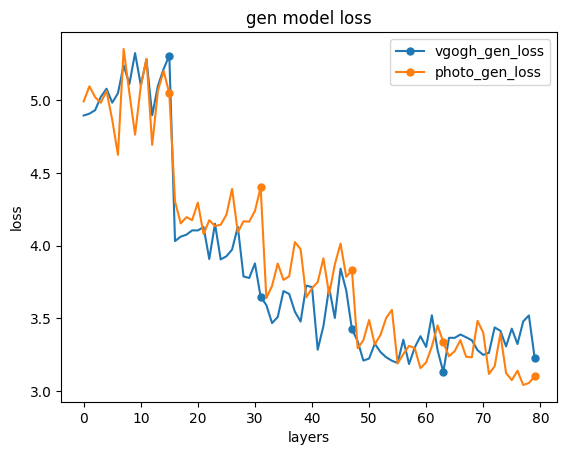

In [30]:
def get_epoch_ends():
    epoch_ends = []
    for i in range(NUMEPOCHS):
        epoch_ends.append((i + 1) * 16 - 1) # subtract 1 to mark the last point of each epoch
    return epoch_ends


#summarize history for discriminator loss

vgogh_disc_loss = np.ravel(history.history['vgogh_disc_loss'])
photo_disc_loss = np.ravel(history.history['photo_disc_loss'])

plt.plot(vgogh_disc_loss[::15])
plt.plot(photo_disc_loss[::15])
plt.title('disc model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['vgogh_disc_loss', 'photo_disc_loss'])
plt.show()

plt.plot(vgogh_disc_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.plot(photo_disc_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.title('disc model loss')
plt.ylabel('loss')
plt.xlabel('layers')
plt.legend(['vgogh_disc_loss', 'photo_disc_loss'])
plt.show()


# summarize history for generator loss

#flatten arrays first
vgogh_gen_loss = np.ravel(history.history['vgogh_gen_loss'])
photo_gen_loss = np.ravel(history.history['photo_gen_loss'])

plt.plot(vgogh_gen_loss[::15])
plt.plot(photo_gen_loss[::15])
plt.title('gen model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['vgogh_disc_loss', 'photo_disc_loss'])
plt.show()

plt.plot(vgogh_gen_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.plot(photo_gen_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.title('gen model loss')
plt.ylabel('loss')
plt.xlabel('layers')
plt.legend(['vgogh_gen_loss', 'photo_gen_loss'])
plt.show()

In [31]:
history.history["photo_gen_loss"]

[array([[[4.992734 , 5.096346 , 5.0220537, 4.9833536],
         [5.063872 , 4.865901 , 4.6251836, 5.3536143],
         [5.0518885, 4.764234 , 5.097747 , 5.284671 ],
         [4.693304 , 5.0657053, 5.201694 , 5.0478444]]], dtype=float32),
 array([[[4.3045664, 4.1532907, 4.196583 , 4.1759167],
         [4.2964687, 4.0801144, 4.1752605, 4.135875 ],
         [4.143922 , 4.21265  , 4.390802 , 4.093171 ],
         [4.1680756, 4.1653347, 4.2388926, 4.4004154]]], dtype=float32),
 array([[[3.6399639, 3.7234335, 3.8773143, 3.7650359],
         [3.7890813, 4.0250754, 3.976351 , 3.6450331],
         [3.7078147, 3.7501106, 3.9133236, 3.6653147],
         [3.8716247, 4.0143642, 3.7860615, 3.8310738]]], dtype=float32),
 array([[[3.294272 , 3.3499775, 3.4888062, 3.3211608],
         [3.3860826, 3.5034242, 3.5585272, 3.189699 ],
         [3.2548218, 3.3107789, 3.2954602, 3.1577516],
         [3.1971443, 3.3073149, 3.4515014, 3.336279 ]]], dtype=float32),
 array([[[3.2393332, 3.2745898, 3.3507285, 3.236